In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from dateutil.relativedelta import relativedelta
import datetime

matplotlib.style.use('ggplot')

In [3]:
from PortfolioConstruction.factor import construct_factor, calc_momentum_ret, calc_beta_ret
from PortfolioConstruction.performance import calc_performance, calc_cum_returns, plot_corr, plot_perf

In [4]:
# Directories
OUTPUT_DIR = '../Outputs/country_clusters/'
INPUT_DIR = '../Data/country_data/'
MACRO_DIR = '../Data/macro_factors/'

# Filter by year
start_date = '2015-09-27'
end_date = '2021-01-31'

# Load Data & Clean to Weekly

## Equity ETFs

In [5]:
# Load ETF returns for Equities
equity_etfs = pd.read_csv(INPUT_DIR + 'ETF_adj_close.csv', index_col=0)
equity_etfs.index = pd.to_datetime(equity_etfs.index)

equity_etfs_w = equity_etfs.resample('W').last()
equity_rets_w = np.log(equity_etfs_w).diff()
equity_rets_w = equity_rets_w.dropna()

## Market Cap

In [6]:
# Load market cap data for countries
country_mkt_cap = pd.read_csv(INPUT_DIR + 'country_market_caps.csv',skiprows=4)
country_mkt_cap = country_mkt_cap[country_mkt_cap.columns[~country_mkt_cap.columns.isin(['Country Code', 'Indicator Name', 'Indicator Code'])]]
country_mkt_cap = country_mkt_cap.T.rename_axis('Date')
country_mkt_cap = country_mkt_cap.rename(columns=country_mkt_cap.iloc[0]).drop(country_mkt_cap.index[0])

# Only select countries in EM universe
# Remove Taiwan since it doesn't exist in the market cap data; change names for Korea, Russia, Egypt for better search
em_countries = equity_rets_w.columns.values
em_countries = np.where(em_countries=='Korea', 'Korea, Rep.', em_countries) 
em_countries = np.where(em_countries=='Russia', 'Russian Federation', em_countries) 
em_countries = np.where(em_countries=='Egypt', 'Egypt, Arab Rep.', em_countries)
em_countries = em_countries[~np.isin(em_countries, 'Taiwan')]

country_mkt_cap = country_mkt_cap[em_countries]
country_mkt_cap.index = pd.to_datetime(country_mkt_cap.index, format='%Y')
country_mkt_cap = country_mkt_cap[(country_mkt_cap.index>='2015-01-01') & (country_mkt_cap.index<=end_date)]
country_mkt_cap.rename(columns={'Korea, Rep.': 'Korea', 'Russian Federation': 'Russia', 'Egypt, Arab Rep.': 'Egypt'}, inplace=True)
country_mkt_cap = country_mkt_cap.fillna(method='ffill')
country_mkt_cap = country_mkt_cap.append(country_mkt_cap.iloc[-1])
country_mkt_cap.index = pd.date_range('2015', '2022', freq='Y')

# Make market cap df to be in weekly
new_df = pd.DataFrame(index=equity_rets_w.index)
def merge_by_year(df):
    df['year'] = list(df.index.year)
    return df

country_mkt_cap = merge_by_year(new_df).merge(merge_by_year(country_mkt_cap), on=['year'])
country_mkt_cap.index = equity_rets_w.index
del country_mkt_cap['year']

## Market ETF

In [7]:
# Market portfolio: Uses iShares MSCI EM ETF
market_etfs = pd.read_csv(INPUT_DIR + 'etf_msci_em_agg_indices.csv',skiprows=5, index_col=0)
market_etfs.columns = ['EEM ETF', 'MSCI EM', 'ACWI ETF']
market_etfs.index = pd.to_datetime(market_etfs.index)

# Market portfolio returns
market_rets_w = market_etfs.resample('W').last()
market_rets_w = np.log(market_rets_w).diff()
market_rets_w = market_rets_w.dropna()

market_rets_w = market_rets_w[(market_rets_w.index>=start_date) & (market_rets_w.index<=end_date)]
market_rets_w['EEM_cum_rets'] = np.exp(market_rets_w['EEM ETF'].cumsum())-1

In [8]:
market_rets_w.to_pickle('../Outputs/equity/equity_EM_agg_market_returns.pkl')

## Country PE Ratios

In [9]:
# Load country PE ratios
country_pe = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', skiprows=51)
country_pe_match = pd.read_csv(MACRO_DIR + 'world_PEratio.csv', nrows=50)
country_pe_match = country_pe_match[['Ticker', 'Country']]
country_pe_dict = country_pe_match.set_index('Ticker')['Country'].to_dict()
country_pe_dict = {k+'_Close': v for k, v in country_pe_dict.items()}

country_pe.index = country_pe['Date']
del country_pe['Date']

# Rename columns
country_pe.rename(country_pe_dict, axis=1, inplace=True)
em_countries_new = list(np.where(em_countries=='Korea, Rep.', 'Korea, Republic Of', em_countries))
for country in ['United Arab Emirates', 'Saudi Arabia', 'Egypt, Arab Rep.', 'Pakistan', 'Qatar']:
    em_countries_new.remove(country)
country_pe = country_pe[em_countries_new]
country_pe.rename(columns={'Korea, Republic Of': 'Korea', 'Russian Federation': 'Russia'}, inplace=True)

country_pe.index = pd.to_datetime(country_pe.index)
country_pe = country_pe[(country_pe.index>=start_date) & (country_pe.index<=end_date)]
# Fillna's with previous values
country_pe = country_pe.fillna(method='ffill')

# Convert to weekly
new_df = pd.DataFrame(index=equity_rets_w.index)
def merge_by_year_month(df):
    df['year'] = list(df.index.year)
    df['month'] = list(df.index.month)
    return df

country_pe = merge_by_year_month(new_df).merge(merge_by_year_month(country_pe), on=['year', 'month'])
country_pe.index = equity_rets_w.index
del country_pe['year']
del country_pe['month']

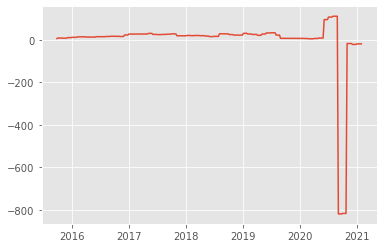

In [40]:
plt.plot(country_pe['Argentina'])

## FF

In [11]:
ff5 = pdr.famafrench.FamaFrenchReader('Emerging_5_Factors',start = '2000-01-01').read()[0]
ff_mom = pdr.famafrench.FamaFrenchReader('Emerging_MOM_Factor',start = '2000-01-01').read()[0]
ff6 = pd.concat([ff5,ff_mom],axis=1)
ff6['Date'] = ff6.index
ff6.index = pd.to_datetime(ff6['Date'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d'))
del ff6['Date']

In [12]:
ff6 = ff6[(ff6.index>='2015-09-01') & (ff6.index<=end_date)]
ff6_rf = np.log(ff6[['RF']]/100*12/52+1)
#ff6_rf = np.log((1+ff6[['RF']]/100)**(1/52))
ff6 = ff6[['SMB', 'HML', 'WML', 'Mkt-RF']]
ff6 = np.log(ff6/100+1)

## Equity Clusters

In [13]:
equity_clusters = pd.read_pickle(OUTPUT_DIR + 'clusters_equity_etf_full.pkl')
equity_clusters = equity_clusters.groupby('cluster_label')['Countries'].apply(list).reset_index()

# Purpose of the Notebook
**Part I: Country Factor Portfolios**
1. Construct country factor
2. Construct portfolios from country-level factors
3. Backtest and construct performance metrics

**Part II: Cluster Factor Portfolios**


# Part I: Country Factor Portfolios
## 1. Construct country factors
### Small cap portfolio
- Use country_mkt_cap as proxy for low capitalization countries.

### Value portfolio
- Use country_pe as proxy for value. This df contains PE ratios by country index.

### Momentum portfolio
- Calculate every week the cumulative trailing weekly returns for $t$-2 to $t$-52 and form three portfolios containing in equal numbers the highest, medium, and lowest momentum countries.

In [14]:
mom_df = calc_momentum_ret(equity_rets_w)

### Beta portfolio
* Calculate every week the country beta against the ETF EM index (EEM) using a rolling sample of 52 weekly observations and create portfolios of lowest beta countries.

In [15]:
beta_df = calc_beta_ret(equity_rets_w, market_rets_w['EEM ETF'])

## 2. Construct portfolios from country-level factors

In [16]:
small_cap_ret, small_cap_port = construct_factor(country_mkt_cap, equity_rets_w, ascending=False)
value_ret, value_port = construct_factor(country_pe, equity_rets_w, ascending=False)
mom_ret, mom_port = construct_factor(mom_df, equity_rets_w, ascending=True)
low_beta_ret, low_beta_port = construct_factor(beta_df, equity_rets_w, ascending=False)

In [17]:
# Excess market returns
# Convert to weekly
new_df_w = pd.DataFrame(index=market_rets_w.index)
ff6_rf = merge_by_year_month(new_df_w).merge(merge_by_year_month(ff6_rf), on=['year', 'month'])
ff6_rf.index = pd.date_range('2015-09-27', '2021-02', freq='W')
del ff6_rf['year']
del ff6_rf['month']

#jan2021 = pd.DataFrame(index=new_df_w.index[-5:])
#jan2021['RF'] = ff6_rf['RF'].iloc[-1]
#ff6_rf = ff6_rf.append(jan2021)
market_rets_w['EEM ETF-RF'] = market_rets_w['EEM ETF'] - ff6_rf['RF']

In [18]:
# Create a single df of all returns
all_port_rets = pd.concat([small_cap_ret, value_ret, mom_ret, low_beta_ret, market_rets_w['EEM ETF-RF'],ff6_rf['RF']], axis=1)
all_port_rets.columns = ['size', 'value', 'momentum', 'low_beta', 'market-rf','rf']
all_port_rets.to_pickle('../Outputs/equity/equity_country_factors_rf.pkl')

In [19]:
# Create a single df of all returns
all_port_rets = pd.concat([small_cap_ret, value_ret, mom_ret, low_beta_ret, market_rets_w['EEM ETF-RF']], axis=1)
all_port_rets.columns = ['size', 'value', 'momentum', 'low_beta', 'market-rf']

## 3. Performance

## Country Factor Portfolio Returns

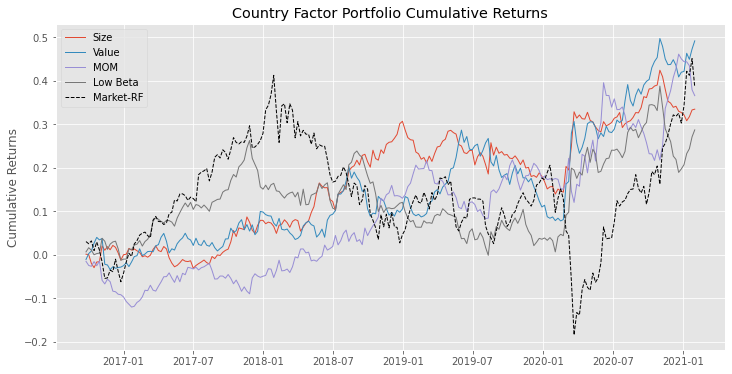

In [20]:
all_port_cum_ret_df = calc_cum_returns(all_port_rets)

# Plot cumulative returns
plot_perf(perf=[all_port_cum_ret_df[x] for x in list(all_port_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_port_cum_ret_df['market-rf_cum_ret'], label=['Size', 'Value', 'MOM', 'Low Beta'], \
          title='Country Factor Portfolio Cumulative Returns')

In [21]:
all_perf = []
for col in all_port_rets.columns:
    perf_ = calc_performance(all_port_rets[col])
    all_perf.append(perf_)

perf_df = pd.DataFrame(all_perf, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = ['Size', 'Value', 'MOM', 'Low Beta', 'Market-RF'])
perf_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
Size,6.82,9.84,0.69,0.94,2.55,12.80,2020-02-02
Value,10.58,11.82,0.90,0.54,4.13,16.22,2020-02-16
MOM,7.37,12.81,0.58,0.54,2.49,12.79,2020-10-18
Low Beta,6.04,12.13,0.50,0.69,3.21,20.89,2019-08-11
Market-RF,7.73,20.41,0.38,-0.61,2.87,42.24,2020-03-22


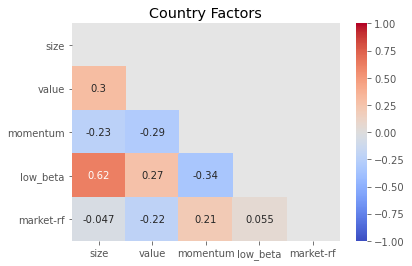

In [22]:
# Correlations of country factors
corr_country_df = plot_corr(all_port_rets, 'Country Factors')
corr_country_df

## FF Factor Portfolio Returns

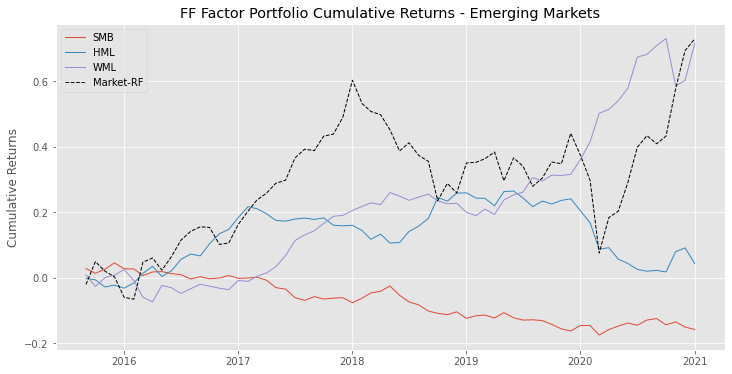

In [23]:
first_date = all_port_cum_ret_df.index[0]
ff6_ = ff6[ff6.index>=first_date]
all_ff_cum_ret_df = calc_cum_returns(ff6)

# Plot cumulative returns
plot_perf(perf=[all_ff_cum_ret_df[x] for x in list(all_ff_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_ff_cum_ret_df['Mkt-RF_cum_ret'], label=list(ff6.columns.values)[:-1], \
          title='FF Factor Portfolio Cumulative Returns - Emerging Markets')

In [24]:
all_perf_ff = []
for col in ff6_.columns:
    perf_ff_ = calc_performance(ff6_[col], time = 12)
    all_perf_ff.append(perf_ff_)

perf_ff_df = pd.DataFrame(all_perf_ff, columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], \
                       index = list(ff6_.columns.values))
perf_ff_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
SMB,-3.96,4.84,-0.82,-0.12,-0.76,18.01,2020-03-01
HML,-0.51,8.11,-0.06,-0.04,1.24,19.52,2020-10-01
WML,13.77,8.24,1.67,-0.83,5.16,8.36,2020-11-01
Mkt-RF,9.74,17.31,0.56,-1.05,3.13,32.91,2020-03-01


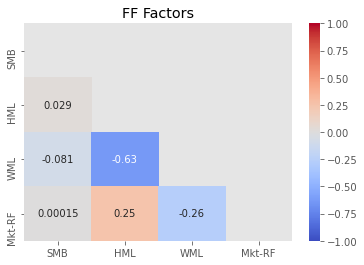

In [25]:
# Correlations of ff factors
corr_ff_df = plot_corr(ff6_, 'FF Factors')
corr_ff_df

## Output

In [26]:
all_port_rets.to_pickle('../Outputs/equity/equity_country_factors.pkl')

# Part II: Cluster Factor Portfolios
Using clusters, construct size, value, momentum, and low beta factors, similar to the country-index approach above.

## 1. Construct cluster factor measures

In [27]:
def calc_cluster_factor_measure(cluster_df, df_factor_measure):
    '''
    Takes country cluster df and country-level factor measures, and constructs cluster-level factor measures
    '''
    
    # Take care of countries that appear in clustering but not in df_factor_measure due to data inavailability
    country_level = list(df_factor_measure.columns)
    all_countries = cluster_df['Countries'].tolist()
    cluster_level = [item for items in all_countries for item in items]
    extras = list(set(cluster_level) - set(country_level))
    
    factor_cluster_dict = {}
    for cluster_num in list(cluster_df['cluster_label'].unique()):
        
        countries_selected = cluster_df[cluster_df['cluster_label']==cluster_num]['Countries'].iloc[0]
        
        # Check whether we have countries in 'extras', if yes remove those countries
        to_remove = list(set(countries_selected).intersection(extras))
        if to_remove:
            countries_selected = [country for country in countries_selected if country not in to_remove]
        
        factor_clusters_df = df_factor_measure[countries_selected]
        avg_cap = factor_clusters_df.mean(axis=1)
        factor_cluster_dict['cluster_'+str(cluster_num)] = avg_cap
    
    cluster_factor_measure = pd.DataFrame(factor_cluster_dict)
    
    return cluster_factor_measure

### Small cap portfolio
- Use country_mkt_cap as proxy for low capitalization clusters. Value-weight countries within a cluster.

In [28]:
cluster_mkt_cap = calc_cluster_factor_measure(equity_clusters, country_mkt_cap)

### Value portfolio
- Use country_pe as proxy for value. This df contains PE ratios by country index.

In [29]:
cluster_pe_ratios = calc_cluster_factor_measure(equity_clusters, country_pe)

### Momentum portfolio
- Calculate every week the cumulative trailing weekly returns for $t$-2 to $t$-52.

In [30]:
avg_cluster_ret = calc_cluster_factor_measure(equity_clusters, equity_rets_w)

In [31]:
cluster_mom_df = calc_momentum_ret(avg_cluster_ret)

### Beta portfolio
* Calculate every week the cluster-level beta against the ETF EM index (EEM) using a rolling sample of 52 weekly observations and create portfolios of lowest beta clusters.

In [32]:
cluster_beta_df = calc_beta_ret(avg_cluster_ret, market_rets_w['EEM ETF'])

## 2. Construct portfolios from cluster-level factors

In [33]:
cluster_size_ret, _ = construct_factor(cluster_mkt_cap, avg_cluster_ret, ascending=False)
cluster_value_ret, _ = construct_factor(cluster_pe_ratios, avg_cluster_ret, ascending=False)
cluster_mom_ret, _ = construct_factor(cluster_mom_df, avg_cluster_ret, ascending=True)
cluster_low_beta_ret, _ = construct_factor(cluster_beta_df, avg_cluster_ret, ascending=False)

In [34]:
# Create a single df of all returns
all_cluster_rets = pd.concat([cluster_size_ret, cluster_value_ret, cluster_mom_ret, cluster_low_beta_ret, market_rets_w['EEM ETF-RF']], axis=1)
all_cluster_rets.columns = ['size', 'value', 'momentum', 'low_beta', 'market-rf']

## 3. Performance

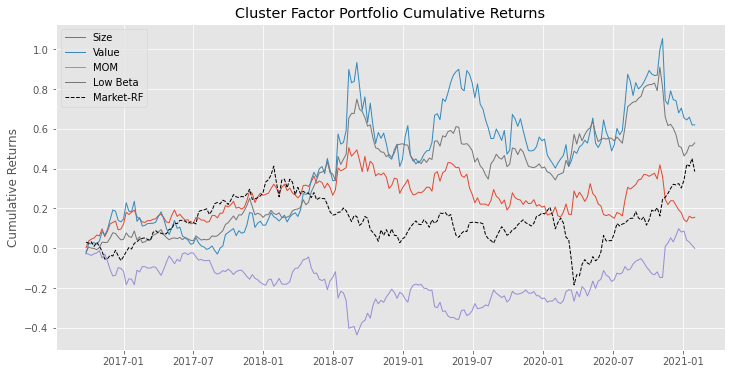

In [35]:
all_cluster_cum_ret_df = calc_cum_returns(all_cluster_rets)

# Plot cumulative returns
plot_perf(perf=[all_cluster_cum_ret_df[x] for x in list(all_cluster_cum_ret_df.columns.values)[:-1]], \
          perf_bm=all_cluster_cum_ret_df['market-rf_cum_ret'], label=['Size', 'Value', 'MOM', 'Low Beta'], \
          title='Cluster Factor Portfolio Cumulative Returns')

In [36]:
all_cluster_perf = []
for col in all_cluster_rets.columns:
    perf_ = calc_performance(all_cluster_rets[col])
    all_cluster_perf.append(perf_)

cluster_perf_df = pd.DataFrame(all_cluster_perf, \
                               columns = ['Mean Return Ann. (%)', 'Std Ann. (%)', 'Sharpe Ratio Ann.', 'Skewness', 'Kurtosis', 'Max Drawdown (%)', 'Max Drawdown Date'], 
                                index = ['Size', 'Value', 'MOM', 'Low Beta', 'Market-RF'])
cluster_perf_df

,Mean Return Ann. (%),Std Ann. (%),Sharpe Ratio Ann.,Skewness,Kurtosis,Max Drawdown (%),Max Drawdown Date
Size,4.90,18.01,0.27,0.50,1.92,24.70,2021-01-10
Value,11.42,28.23,0.40,0.59,4.25,27.46,2020-02-02
MOM,-0.01,26.40,-0.00,-0.70,7.09,42.90,2018-09-02
Low Beta,10.19,17.11,0.60,0.64,3.52,23.35,2021-01-03
Market-RF,7.73,20.41,0.38,-0.61,2.87,42.24,2020-03-22


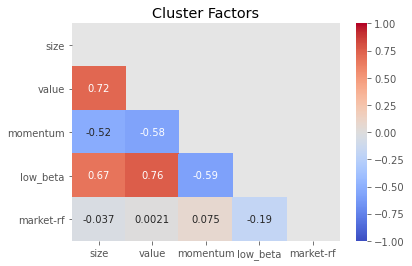

In [37]:
# Correlations of cluster factors
corr_cluster_df = plot_corr(all_cluster_rets, 'Cluster Factors')
corr_cluster_df

## Outputs

In [38]:
all_cluster_rets.to_pickle('../Outputs/equity/equity_cluster_factors.pkl')